# Applied Machine Learning Project 2: Classification using XGBoost Models
**Srinath Murali Krishnan | NetID:SMK220008**

# Data Importing and Preliminary Analysis

1) We first import the data and identify the target variable
2) We describe the data and observe column values

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,roc_auc_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from interpret.blackbox import ShapKernel
from interpret import show

In [3]:
# Import Dataset
X = pd.read_csv('SBA_loans_project_2.csv')

In [8]:
X

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
0,0,FORT LEE,NJ,7024,BNB HANA BANK NATL ASSOC,NJ,425120,2,1.0,0,2,1,1,Y,N,10000.0,0.0,10000.0,5000.0,0
1,1,WESTWEGO,LA,70094,JEDCO DEVELOPMENT CORPORATION,LA,812331,62,1.0,6,0,1,1,0,N,353000.0,0.0,353000.0,353000.0,0
2,2,DENVER,CO,80209,WELLS FARGO BANK NATL ASSOC,SD,541611,4,1.0,1,4,1,1,Y,N,100000.0,0.0,100000.0,50000.0,0
3,3,WRANGELL,AK,99929,FIRST BANK,AK,446110,3,2.0,0,0,1,0,N,Y,75000.0,0.0,75000.0,67500.0,0
4,4,MALVERN,AR,72104,CITICAPITAL SMALL BUS. FINANCE,TX,0,1,2.0,0,0,52000,1,0,Y,45000.0,0.0,45000.0,36000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799351,799351,PORTAGE,MI,49002,MICHIGAN COMMERCE BANK,MI,0,1,2.0,0,0,1,0,N,Y,9500.0,0.0,9500.0,8550.0,0
799352,799352,DECATUR,AL,35603,RENASANT BANK,AL,484121,7,1.0,0,0,1,1,0,Y,52037.0,0.0,52037.0,44231.0,0
799353,799353,LITTLE ROCK,AR,72201,REGIONS BANK,AR,0,1,1.0,0,0,1,0,N,N,50000.0,0.0,50000.0,45000.0,0
799354,799354,ST. CHARLES,IL,60174,OLD SECOND NATIONAL BANK,IL,235310,12,1.0,0,0,1,0,N,N,175000.0,0.0,175000.0,143500.0,0


In [10]:
X.drop('index',axis=1,inplace=True)

In [12]:
X.shape

(799356, 19)

In [14]:
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input X_valFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:200].to_dict())
                
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'X_valtype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [16]:
describe_more(X)

,A_Variable,Levels,X_valtype,Min Length,Max Length,Level_Values
0,City,31040,object,1,30,"{'LOS ANGELES': 10298, 'HOUSTON': 9141, 'NEW Y..."
1,State,51,object,2,3,"{'CA': 116234, 'TX': 62719, 'NY': 51208, 'FL':..."
2,Zip,32704,int64,1,5,"{90015: 842, 10001: 836, 93401: 728, 90010: 66..."
3,Bank,5692,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 77159, 'WELLS F..."
4,BankState,56,object,2,3,"{'CA': 105117, 'NC': 70706, 'IL': 58629, 'OH':..."
5,NAICS,1308,int64,1,6,"{0: 179717, 722110: 24777, 722211: 17231, 8111..."
6,NoEmp,571,int64,1,4,"{1: 136985, 2: 123019, 3: 80527, 4: 65536, 5: ..."
7,NewExist,3,float64,3,3,"{1.0: 573237, 2.0: 225071, 0.0: 934}"
8,CreateJob,231,int64,1,4,"{0: 559592, 1: 56031, 2: 51346, 3: 25591, 4: 1..."
9,RetainedJob,338,int64,1,4,"{0: 391657, 1: 78866, 2: 68337, 3: 44388, 4: 3..."


# Data Cleaning Step:

In [18]:
# check if any columns still have null values
cat=[]
for col in X.columns:
    if X[col].isna().any() == True:
        print(col)

City
State
Bank
BankState
NewExist
RevLineCr
LowDoc


In [19]:
X['RevLineCr'].value_counts()

RevLineCr
N    373816
0    228950
Y    178985
T     13523
1        19
R        12
`        10
2         5
C         2
,         1
Q         1
3         1
5         1
A         1
4         1
7         1
.         1
-         1
Name: count, dtype: int64

In [20]:
X['LowDoc'].value_counts()

LowDoc
N    696070
Y     97961
0      1316
C       681
S       526
A       436
R        65
1         1
Name: count, dtype: int64

In [21]:
#replacing values in RevLineCr with Y and N
X['RevLineCr']=X['RevLineCr'].replace('0','N')
X['RevLineCr']=X['RevLineCr'].replace('1','Y')
X['RevLineCr']=X['RevLineCr'].replace('T','Y')

In [22]:
#replacing values in RevLineCr with null that have no context
X['RevLineCr'] = X['RevLineCr'].apply(lambda x: x if x in ['Y', 'N'] else np.nan)


X['RevLineCr'].fillna(X['RevLineCr'].mode()[0], inplace=True)

In [23]:
#replacing values in LowDoc with Y and N
X['LowDoc']=X['LowDoc'].replace('0','N')
X['LowDoc']=X['LowDoc'].replace('S','Y')
X['LowDoc']=X['LowDoc'].replace('A','N')

In [24]:
#replacing values in LowDoc with null that have no context
X['LowDoc'] = X['LowDoc'].apply(lambda x: x if x in ['Y', 'N'] else np.nan)


X['LowDoc'].fillna(X['LowDoc'].mode()[0], inplace=True)


In [25]:
# creating a target variable y for MIS_Status
y = X['MIS_Status'].to_frame()

In [26]:
# We drop MIS_Status because it is the target
X.drop('MIS_Status',axis=1,inplace=True)

In [27]:
#imputing null values
cat=['City','State','Bank','BankState']
num=['NewExist']
for i in cat:
    X[i].fillna(X[i].mode().iloc[0],inplace=True)
for i in num:
    X[i].fillna(X[i].median(),inplace=True)

# Data Encoding Step and Feature Engineering

1) We construct 15 new features from the existing features in the dataset
2) The task is to create better features packed with more contextual information
3) We further use VIF for feature selection and getting rid of any possible multicollinearity

In [30]:
# using the train test split function
X_train, X_val, y_train, y_val = train_test_split(
  X,y , random_state=104,test_size=0.25, shuffle=True)

In [31]:
# Assuming 'X_train' is your X_trainFrame and already includes basic preprocessing

# Feature 1: Loan Size Category
X_train['LoanSizeCategory'] = pd.cut(X_train['GrAppv'], bins=[0, 50000, 150000, 350000, 1000000, 5000000], labels=['Micro', 'Small', 'Medium', 'Large', 'Very Large'])

# Feature 2: Job Creation Category
X_train['JobCreationCategory'] = pd.cut(X_train['CreateJob'] + X_train['RetainedJob'], bins=[-1, 0, 5, 10, 20, 50, 100, float('inf')], labels=['None', 'Few', 'Some', 'Moderate', 'Many', 'A Lot', 'Massive'])

# Feature 3: High-Risk Industry (NAICxS codes starting with 72 are typically hospitality, considered higher risk)
X_train['HighRiskIndustry'] = X_train['NAICS'].apply(lambda x: 1 if str(x).startswith('72') else 0)

# Feature 4: Loan/Grant Ratio
X_train['LoanGrantRatio'] = X_train['GrAppv'] / X_train['SBA_Appv']

# Feature 5: Per Employee Investment
X_train['PerEmployeeInvestment'] = X_train['GrAppv'] / (X_train['NoEmp'] + 1)  # Avoid division by zero


In [32]:

# Feature 6: Business Age - New business flag (assuming NewExist codes: 1 for existing, 2 for new)
X_train['NewBusiness'] = X_train['NewExist'].apply(lambda x: 1 if x == 2 else 0)

# Feature 7: Urban Business - Flag for businesses in urban areas (assuming UrbanRural codes: 1 for urban, 2 for rural, 0 for undefined)
X_train['UrbanBusiness'] = X_train['UrbanRural'].apply(lambda x: 1 if x == 1 else 0)

# Feature 8: Franchise Flag - Flag for whether the business is a franchise (assuming FranchiseCode: 1 or 0 indicates not a franchise, any other value indicates a franchise)
X_train['FranchiseFlag'] = X_train['FranchiseCode'].apply(lambda x: 0 if x == 1 or x == 0 else 1)

# Feature 9: Expansion Plan - Flag businesses creating more jobs than retaining (CreateJob > RetainedJob)
X_train['ExpansionPlan'] = X_train.apply(lambda x: 1 if x['CreateJob'] > x['RetainedJob'] else 0, axis=1)

# Feature 10: Economic Sector - Extract broader economic sector from NAICS code (first two digits of NAICS code)
X_train['EconomicSector'] = X_train['NAICS'].apply(lambda x: int(str(x)[:2]) if x > 0 else 0)

In [33]:
# Feature 11: Credit Utilization Ratio
X_train['CreditUtilizationRatio'] = X_train['GrAppv'] / X_train['SBA_Appv']

# Feature 12: Profitability Indicator (Profitability as Retained Jobs greater than Created Jobs)
X_train['ProfitabilityIndicator'] = (X_train['RetainedJob'] > X_train['CreateJob']).astype(int)

# Feature 13: Seasonal Adjustment (Seasonal industries, e.g., Retail in Q4 - Using NAICS)
seasonal_naics = [44, 45]  # Retail trade NAICS codes
X_train['SeasonalAdjustment'] = X_train['NAICS'].apply(lambda x: 1 if int(str(x)[:2]) in seasonal_naics else 0)

# Feature 14: Geographic Region (Categorizing ZIP codes into regions, assuming arbitrary division for example)
X_train['GeographicRegion'] = pd.cut(X_train['Zip'], bins=4, labels=['North', 'South', 'East', 'West'])


# Feature 15: Loan Size per Employee
X_train['LoanPerEmployee'] = X_train['GrAppv'] / (X_train['NoEmp'] + 1)  # Adding 1 to avoid division by zero


In [34]:
# Assuming 'X_val' is your X_valFrame and already includes basic preprocessing

# Feature 1: Loan Size Category
X_val['LoanSizeCategory'] = pd.cut(X_val['GrAppv'], bins=[0, 50000, 150000, 350000, 1000000, 5000000], labels=['Micro', 'Small', 'Medium', 'Large', 'Very Large'])

# Feature 2: Job Creation Category
X_val['JobCreationCategory'] = pd.cut(X_val['CreateJob'] + X_val['RetainedJob'], bins=[-1, 0, 5, 10, 20, 50, 100, float('inf')], labels=['None', 'Few', 'Some', 'Moderate', 'Many', 'A Lot', 'Massive'])

# Feature 3: High-Risk Industry (NAICxS codes starting with 72 are typically hospitality, considered higher risk)
X_val['HighRiskIndustry'] = X_val['NAICS'].apply(lambda x: 1 if str(x).startswith('72') else 0)

# Feature 4: Loan/Grant Ratio
X_val['LoanGrantRatio'] = X_val['GrAppv'] / X_val['SBA_Appv']

# Feature 5: Per Employee Investment
X_val['PerEmployeeInvestment'] = X_val['GrAppv'] / (X_val['NoEmp'] + 1)  # Avoid division by zero

In [35]:

# Feature 6: Business Age - New business flag (assuming NewExist codes: 1 for existing, 2 for new)
X_val['NewBusiness'] = X_val['NewExist'].apply(lambda x: 1 if x == 2 else 0)

# Feature 7: Urban Business - Flag for businesses in urban areas (assuming UrbanRural codes: 1 for urban, 2 for rural, 0 for undefined)
X_val['UrbanBusiness'] = X_val['UrbanRural'].apply(lambda x: 1 if x == 1 else 0)

# Feature 8: Franchise Flag - Flag for whether the business is a franchise (assuming FranchiseCode: 1 or 0 indicates not a franchise, any other value indicates a franchise)
X_val['FranchiseFlag'] = X_val['FranchiseCode'].apply(lambda x: 0 if x == 1 or x == 0 else 1)

# Feature 9: Expansion Plan - Flag businesses creating more jobs than retaining (CreateJob > RetainedJob)
X_val['ExpansionPlan'] = X_val.apply(lambda x: 1 if x['CreateJob'] > x['RetainedJob'] else 0, axis=1)

# Feature 10: Economic Sector - Extract broader economic sector from NAICS code (first two digits of NAICS code)
X_val['EconomicSector'] = X_val['NAICS'].apply(lambda x: int(str(x)[:2]) if x > 0 else 0)

In [36]:
# Feature 11: Credit Utilization Ratio
X_val['CreditUtilizationRatio'] = X_val['GrAppv'] / X_val['SBA_Appv']

# Feature 12: Profitability Indicator (Profitability as Retained Jobs greater than Created Jobs)
X_val['ProfitabilityIndicator'] = (X_val['RetainedJob'] > X_val['CreateJob']).astype(int)

# Feature 13: Seasonal Adjustment (Seasonal industries, e.g., Retail in Q4 - Using NAICS)
seasonal_naics = [44, 45]  # Retail trade NAICS codes
X_val['SeasonalAdjustment'] = X_val['NAICS'].apply(lambda x: 1 if int(str(x)[:2]) in seasonal_naics else 0)

# Feature 14: Geographic Region (Categorizing ZIP codes into regions, assuming arbitrary division for example)
X_val['GeographicRegion'] = pd.cut(X_val['Zip'], bins=4, labels=['North', 'South', 'East', 'West'])


# Feature 15: Loan Size per Employee
X_val['LoanPerEmployee'] = X_val['GrAppv'] / (X_val['NoEmp'] + 1)  # Adding 1 to avoid division by zero


In [37]:
# convert columns fo category type to object 
for col in X_train.select_dtypes(include=['category']).columns:
    X_train[col] = X_train[col].astype('object')
    X_val[col] = X_val[col].astype('object')

In [38]:
describe_more(X_train)

,A_Variable,Levels,X_valtype,Min Length,Max Length,Level_Values
0,City,27654,object,1,30,"{'LOS ANGELES': 7778, 'HOUSTON': 6840, 'NEW YO..."
1,State,51,object,2,2,"{'CA': 87368, 'TX': 47075, 'NY': 38453, 'FL': ..."
2,Zip,30402,int64,1,5,"{90015: 639, 10001: 603, 93401: 537, 90010: 49..."
3,Bank,5423,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 59056, 'WELLS F..."
4,BankState,56,object,2,2,"{'CA': 79987, 'NC': 53195, 'IL': 43896, 'OH': ..."
5,NAICS,1299,int64,1,6,"{0: 134882, 722110: 18496, 722211: 12872, 8111..."
6,NoEmp,515,int64,1,4,"{1: 102481, 2: 92382, 3: 60503, 4: 49334, 5: 4..."
7,NewExist,3,float64,3,3,"{1.0: 430055, 2.0: 168765, 0.0: 697}"
8,CreateJob,215,int64,1,4,"{0: 419456, 1: 42005, 2: 38635, 3: 19127, 4: 1..."
9,RetainedJob,305,int64,1,4,"{0: 293469, 1: 59148, 2: 51254, 3: 33376, 4: 2..."


In [39]:
# compute the vif for all given features
def compute_vif(considered_features):
    
    X = X_train[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [40]:

# Assuming 'X_train' is the X_trainFrame after feature engineering
# Assuming 'target' is the name of the target column in 'X_train'

# Identify categorical variables with less than 10 unique values for one-hot encoding
cat_vars_for_one_hot = [col for col in X_train.columns if (X_train[col].nunique() < 10) and (X_train[col].dtype == 'object')]

# Now, for target and WOE encoding, identify the remaining categorical variables
remaining_cat_vars = [col for col in X_train.columns if (X_train[col].dtype == 'object') and (col not in cat_vars_for_one_hot)]

numeric=[col for col in X_train.columns if (X_train[col].dtype != 'object') ]

In [41]:
compute_vif(numeric)

/var/folders/x3/5n0yyb7911zg532jx71xlkrr0000gn/T/ipykernel_25054/3288876314.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,Zip,1.028380e+00
1,NAICS,1.566982e+04
2,NoEmp,1.028312e+00
3,NewExist,1.760857e+02
4,CreateJob,8.768533e+01
5,RetainedJob,8.768818e+01
6,FranchiseCode,4.232866e+00
7,UrbanRural,1.611560e+00
8,DisbursementGross,1.927628e+01
9,BalanceGross,1.000033e+00


In [42]:
drops=['NewExist','CreateJob','RetainedJob','NAICS','GrAppv','SBA_Appv']
res = [item for item in numeric if item not in drops]
compute_vif(res)

/var/folders/x3/5n0yyb7911zg532jx71xlkrr0000gn/T/ipykernel_25054/3288876314.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,Zip,1.027653
1,NoEmp,1.025017
2,FranchiseCode,4.232143
3,UrbanRural,1.544218
4,DisbursementGross,1.500325
5,BalanceGross,1.000025
6,HighRiskIndustry,1.239514
7,LoanGrantRatio,inf
8,PerEmployeeInvestment,inf
9,NewBusiness,1.105064


# Data Encoding Step

1) This step involves identifying the numerical and categorical columns: a) for one hot and b) woe encoding
2) The categorical columns undergo encoding based on whether they have less than 10 values or not
3) further we scale the numerical columns
4) we save the encoders/scalers

In [45]:
# Initialize WOE encoder for categorical variables
woe_encoder = ce.WOEEncoder(cols=remaining_cat_vars)

# Fit the WOE encoder on the training data
# Assuming 'target' is the name of your target variable in the training data
woe_encoder.fit(X_train[remaining_cat_vars], y_train)

# Transform the training and validation data using the fitted encoder
X_train = X_train.join(woe_encoder.transform(X_train[remaining_cat_vars]).add_suffix('_woe'))
X_val = X_val.join(woe_encoder.transform(X_val[remaining_cat_vars]).add_suffix('_woe'))


In [46]:
# Assuming woe_encoder is your fitted encoder
with open('woe_encoder.pkl', 'wb') as file:
    pickle.dump(woe_encoder, file)

In [47]:
# using Standard Scaler to Scale the numerical columns
scaler = StandardScaler()
# Fit the scaler on the training data
scaler.fit(X_train[res])
# Transform the training and validation data using the fitted scaler
X_train[res] = scaler.transform(X_train[res])
X_val[res] = scaler.transform(X_val[res])

In [48]:
# Assuming scaler is your fitted scaler
with open('standardscaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [49]:
# drop the unencoded columns
X_train.drop(columns=remaining_cat_vars,axis=1,inplace=True)
X_train.drop(columns=drops,axis=1,inplace=True)

In [50]:
X_train

,Zip,NoEmp,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,LoanSizeCategory,JobCreationCategory,...,EconomicSector,CreditUtilizationRatio,ProfitabilityIndicator,SeasonalAdjustment,GeographicRegion,LoanPerEmployee,City_woe,State_woe,Bank_woe,BankState_woe
238082,-1.190578,-0.152928,-0.215596,0.374426,Y,N,-0.529983,-0.002309,Micro,Few,...,0.168425,1.217013,1.197136,2.464453,North,-0.286692,-0.396073,-0.243511,-0.395310,-0.060923
147244,-1.602453,0.129638,-0.215517,1.921078,N,N,-0.405535,-0.002309,Small,None,...,0.624937,-0.809205,-0.835327,-0.405770,North,-0.421824,-0.752748,-0.583887,-1.112751,-1.087835
303969,-0.657035,-0.123184,-0.215517,-1.172226,N,Y,-0.579876,-0.002309,Micro,None,...,-1.505454,-0.628293,-0.835327,-0.405770,South,-0.346645,0.360253,0.562885,0.451225,-0.094317
771227,0.605874,-0.019081,-0.215517,0.374426,N,Y,-0.440403,-0.002309,Small,None,...,1.576005,-0.809205,-0.835327,-0.405770,East,-0.377530,0.212645,-0.080001,-0.420498,-0.412898
664392,-1.269446,0.159382,-0.215596,0.374426,N,N,-0.562442,-0.002309,Micro,Many,...,-0.250045,1.217013,1.197136,-0.405770,North,-0.458731,-0.369756,0.152945,-0.395310,-0.060923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578687,1.128902,-0.108312,-0.215517,0.374426,N,N,0.211632,-0.002309,Medium,Few,...,0.548852,-0.423259,-0.835327,-0.405770,West,0.351209,0.353412,0.343351,0.545084,0.274046
170150,1.001816,0.010663,-0.215517,0.374426,N,N,-0.342773,-0.002309,Small,Moderate,...,1.233620,1.217013,1.197136,-0.405770,West,-0.359865,0.060359,0.196756,0.560221,0.664554
516750,-0.676175,-0.138056,-0.215596,0.374426,Y,N,-0.556340,-0.002309,Micro,Few,...,0.320596,1.217013,1.197136,-0.405770,South,-0.406598,0.491230,0.562885,0.560221,0.664554
115417,-0.469644,-0.123184,0.605738,-1.172226,N,N,-0.091721,-0.002309,Medium,None,...,-1.505454,-0.423259,-0.835327,-0.405770,South,0.212917,-0.453893,-0.109206,-0.823998,-0.645976


In [51]:
#steps repeated for validation
X_val.drop(columns=remaining_cat_vars,axis=1,inplace=True)
X_val.drop(columns=drops,axis=1,inplace=True)

In [52]:
# Initialize the OneHotEncoder
ohe_encoder = OneHotEncoder(sparse=False, drop='first')  # `drop='first'` to drop the first category to avoid multicollinearity
# LoanSizeCategory: Column Dropped is LoanSizeCategoryLarge
# JobCreationCategory: Column Dropped is JobCreationCategoryFew
# RevLineCr: Column Dropped is RevLineCrN
# LowDoc: Column Dropped is LowDocN
# GeographicRegion: Column dropped is East
# Fit the encoder on the training data
ohe_encoder.fit(X_train[cat_vars_for_one_hot])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [54]:
# Assuming onehot_encoder is your fitted encoder
with open('onehot_encoder.pkl', 'wb') as file:
    pickle.dump(ohe_encoder, file)

In [58]:
x_train_ohe = ohe_encoder.transform(X_train[cat_vars_for_one_hot])
# Convert to DataFrame and name columns
columns = ohe_encoder.get_feature_names_out(cat_vars_for_one_hot)
x_train_ohe = pd.DataFrame(x_train_ohe, columns=columns, index=X_train.index)

# Repeat for validation/test data
x_val_ohe = ohe_encoder.transform(X_val[cat_vars_for_one_hot])
x_val_ohe = pd.DataFrame(x_val_ohe, columns=columns, index=X_val.index)

In [60]:
# add onehot encoded columns to x_train and x_val
X_train = pd.concat([X_train.drop(columns=cat_vars_for_one_hot), x_train_ohe], axis=1)

In [62]:
X_val = pd.concat([X_val.drop(columns=cat_vars_for_one_hot), x_val_ohe], axis=1)

In [66]:
X_train

,Zip,NoEmp,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,HighRiskIndustry,LoanGrantRatio,PerEmployeeInvestment,NewBusiness,...,LoanSizeCategory_nan,JobCreationCategory_Few,JobCreationCategory_Many,JobCreationCategory_Massive,JobCreationCategory_Moderate,JobCreationCategory_None,JobCreationCategory_Some,GeographicRegion_North,GeographicRegion_South,GeographicRegion_West
238082,-1.190578,-0.152928,-0.215596,0.374426,-0.529983,-0.002309,-0.284073,1.217013,-0.286692,1.597616,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
147244,-1.602453,0.129638,-0.215517,1.921078,-0.405535,-0.002309,-0.284073,-0.809205,-0.421824,-0.625933,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
303969,-0.657035,-0.123184,-0.215517,-1.172226,-0.579876,-0.002309,-0.284073,-0.628293,-0.346645,1.597616,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
771227,0.605874,-0.019081,-0.215517,0.374426,-0.440403,-0.002309,-0.284073,-0.809205,-0.377530,1.597616,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
664392,-1.269446,0.159382,-0.215596,0.374426,-0.562442,-0.002309,-0.284073,1.217013,-0.458731,-0.625933,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578687,1.128902,-0.108312,-0.215517,0.374426,0.211632,-0.002309,-0.284073,-0.423259,0.351209,1.597616,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
170150,1.001816,0.010663,-0.215517,0.374426,-0.342773,-0.002309,3.520219,1.217013,-0.359865,-0.625933,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
516750,-0.676175,-0.138056,-0.215596,0.374426,-0.556340,-0.002309,-0.284073,1.217013,-0.406598,1.597616,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
115417,-0.469644,-0.123184,0.605738,-1.172226,-0.091721,-0.002309,-0.284073,-0.423259,0.212917,1.597616,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Model Training Step

1) We run a dry model with random hyperparameters 
2) We compute the classification report for the corresponding model 
3) We analyze the metrics and identify where the tuning must be done

In [280]:
#XGBoost model defined and fit
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [281]:
y_pred = model.predict(X_val)

In [282]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [283]:
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy with default parameters: {accuracy * 100:.2f}%")

Accuracy with default parameters: 84.93%


In [284]:
roc_auc_score(y_val, y_pred)

0.6375089401279267

In [285]:
# Classification report of the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91    164814
           1       0.65      0.31      0.42     35025

    accuracy                           0.85    199839
   macro avg       0.76      0.64      0.67    199839
weighted avg       0.83      0.85      0.83    199839



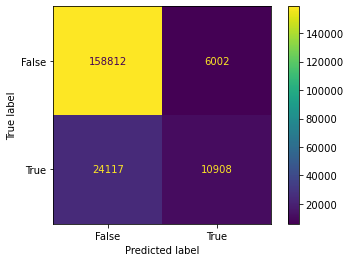

In [286]:
# Confusion matrix for the model
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val, y_pred), display_labels = [False, True])
cm_display.plot()

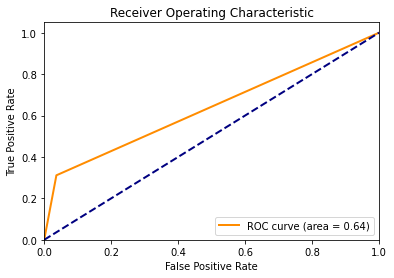

In [287]:
# Calculating ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Fine Tuning

1) We first define the searchspace for our xgboost model tuning
2) We experiment with different hyperparameters such as depth, learning rate, subsamples etc.
3) After running GridSearch, we use different class weights to compare results
4) We pick the best hyperparameters based on our tuning process

In [79]:
negative_examples = len(y[y == 0])
positive_examples = len(y[y == 1])
scale_pos_weight = negative_examples / positive_examples


In [210]:
# Set up the search space for gridsearch
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [200, 300],
    'subsample': [0.8, 0.9, 1],
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best AUC found: ", grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time= 5.8min
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9; total time= 8.4min
[CV] END learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time= 6.5min
[CV] END learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time= 9.0min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time= 7.3min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1; total time= 6.9min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1; total time=11.3min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1; total time= 5.2min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time= 8.3min
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, subsample=1; total time= 6.9min
[CV] END le

In [212]:
# Optional: Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
test_auc = roc_auc_score(y_val, y_pred_proba)
print(f"validation AUC: {test_auc:.4f}")

validation AUC: 0.8236


In [214]:
weights= [scale_pos_weight, scale_pos_weight * 0.5, scale_pos_weight * 2,scale_pos_weight * 4,scale_pos_weight * 10] 

In [216]:
for weight in weights:
    xg = xgb.XGBClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 300, subsample= 0.8,scale_pos_weight=weight)
    xg.fit(X_train, y_train)
    y_pred = xg.predict_proba(X_val)[:, 1]
    print(f"Class weights: {weight}")
    print(roc_auc_score(y_val, y_pred))

Class weights: 1.0
0.8235867285759206
Class weights: 0.5
0.8230225117307632
Class weights: 2.0
0.8237168025726871
Class weights: 4.0
0.8237854619790854
Class weights: 10.0
0.8235578297779964


# Best Model

1) We have identified the best model so we simply train the model
2) We find the ideal threshold for our model
3) We compute the metrics and export the model for scoring function

In [81]:
#Fit the model with best hyperparameters
final_model=xgb.XGBClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 300, subsample= 0.8,scale_pos_weight=scale_pos_weight * 4)
final_model.fit(X_train, y_train)
y_pred = final_model.predict_proba(X_val)[:, 1]
print(roc_auc_score(y_val, y_pred))

0.8247334480145537


In [82]:
# Classification report of the model
print(classification_report(y_val,final_model.predict(X_val) ))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85    164814
           1       0.41      0.70      0.51     35025

    accuracy                           0.77    199839
   macro avg       0.67      0.74      0.68    199839
weighted avg       0.83      0.77      0.79    199839



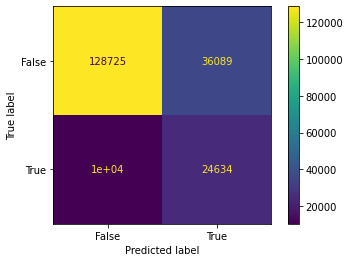

In [83]:
# Confusion matrix for the model
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val,final_model.predict(X_val)), display_labels = [False, True])
cm_display.plot()

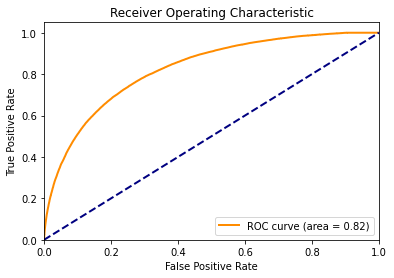

In [84]:
# Calculating ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Threshold Calculation

We calculate Threshold based on f1 macro 

In [87]:
# Find optimal threshold using F1 macro score
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_val, (final_model.predict_proba(X_val)[:, 1] > threshold).astype(int), average='macro') for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]

print("Optimal Threshold using F1 Macro Score:", optimal_threshold)

Optimal Threshold using F1 Macro Score: 0.63


# Permutation Feature Importance

In [89]:
from sklearn.inspection import permutation_importance
import numpy as np

In [90]:
result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)

# Get the mean importances and standard deviations
importances_mean = result.importances_mean
importances_std = result.importances_std

# Feature names
feature_names = X_val.columns

NameError: name 'model' is not defined

In [ ]:
# Sort the feature importances in descending order and get their indices
sorted_idx = np.argsort(importances_mean)[::-1]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_idx)), importances_mean[sorted_idx], yerr=importances_std[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)
plt.title('Permutation Importances (Validation Set)')
plt.show()

# Shapley Values

In [94]:
X_test=pd.read_csv('SBA_loans_project_2_holdout_students_valid.csv')

In [96]:
X_test['RevLineCr']=X_test['RevLineCr'].replace('0','N')
X_test['RevLineCr']=X_test['RevLineCr'].replace('1','Y')
X_test['RevLineCr']=X_test['RevLineCr'].replace('T','Y')
#replacing values in RevLineCr with null that have no context
X_test['RevLineCr'] = X_test['RevLineCr'].apply(lambda x: x if x in ['Y', 'N'] else np.nan)


X_test['RevLineCr'].fillna(X_test['RevLineCr'].mode()[0], inplace=True)

#replacing values in LowDoc with Y and N
X_test['LowDoc']=X_test['LowDoc'].replace('0','N')
X_test['LowDoc']=X_test['LowDoc'].replace('S','Y')
X_test['LowDoc']=X_test['LowDoc'].replace('A','N')

X_test['LowDoc'] = X_test['LowDoc'].apply(lambda x: x if x in ['Y', 'N'] else np.nan)


X_test['LowDoc'].fillna(X_test['LowDoc'].mode()[0], inplace=True)

#extract index column 
index=X_test[['index']]
X_test.drop('index',inplace=True,axis=1,errors='ignore')
cat=[]
num=[]
colu=[]
for col in X_test.columns:
    if X_test[col].isna().any() == True:
        colu.append(col)
num=[col for col in colu if (X_test[col].dtype != 'object') ] 
cat=[col for col in colu if (X_test[col].dtype == 'object') ]
#imputing null values
for i in cat:
    X_test[i].fillna(X_test[i].mode().iloc[0],inplace=True)
for i in num:
    X_test[i].fillna(X_test[i].median(),inplace=True)
# Fearure engineering
# Feature 1: Loan Size Category
X_test['LoanSizeCategory'] = pd.cut(X_test['GrAppv'], bins=[0, 50000, 150000, 350000, 1000000, 5000000], labels=['Micro', 'Small', 'Medium', 'Large', 'Very Large'])

    # Feature 2: Job Creation Category
X_test['JobCreationCategory'] = pd.cut(X_test['CreateJob'] + X_test['RetainedJob'], bins=[-1, 0, 5, 10, 20, 50, 100, float('inf')], labels=['None', 'Few', 'Some', 'Moderate', 'Many', 'A Lot', 'Massive'])

    # Feature 3: High-Risk Industry (NAICS codes starting with 72 are typically hospitality, considered higher risk)
X_test['HighRiskIndustry'] = X_test['NAICS'].apply(lambda x: 1 if str(x).startswith('72') else 0)

    # Feature 4: Loan/Grant Ratio
X_test['LoanGrantRatio'] = X_test['GrAppv'] / X_test['SBA_Appv']

    # Feature 5: Per Employee Investment
X_test['PerEmployeeInvestment'] = X_test['GrAppv'] / (X_test['NoEmp'] + 1)  # Avoid division by zero



    # Feature 6: Business Age - New business flag (assuming NewExist codes: 1 for existing, 2 for new)
X_test['NewBusiness'] = X_test['NewExist'].apply(lambda x: 1 if x == 2 else 0)

    # Feature 7: Urban Business - Flag for businesses in urban areas (assuming UrbanRural codes: 1 for urban, 2 for rural, 0 for undefined)
X_test['UrbanBusiness'] = X_test['UrbanRural'].apply(lambda x: 1 if x == 1 else 0)

    # Feature 8: Franchise Flag - Flag for whether the business is a franchise (assuming FranchiseCode: 1 or 0 indicates not a franchise, any other value indicates a franchise)
X_test['FranchiseFlag'] = X_test['FranchiseCode'].apply(lambda x: 0 if x == 1 or x == 0 else 1)

    # Feature 9: Expansion Plan - Flag businesses creating more jobs than retaining (CreateJob > RetainedJob)
X_test['ExpansionPlan'] = X_test.apply(lambda x: 1 if x['CreateJob'] > x['RetainedJob'] else 0, axis=1)

    # Feature 10: Economic Sector - Extract broader economic sector from NAICS code (first two digits of NAICS code)
X_test['EconomicSector'] = X_test['NAICS'].apply(lambda x: int(str(x)[:2]) if x > 0 else 0)

# Feature 11: Credit Utilization Ratio
X_test['CreditUtilizationRatio'] = X_test['GrAppv'] / X_test['SBA_Appv']

# Feature 12: Profitability Indicator (Profitability as Retained Jobs greater than Created Jobs)
X_test['ProfitabilityIndicator'] = (X_test['RetainedJob'] > X_test['CreateJob']).astype(int)

# Feature 13: Seasonal Adjustment (Seasonal industries, e.g., Retail in Q4 - Using NAICS)
seasonal_naics = [44, 45]  # Retail trade NAICS codes
X_test['SeasonalAdjustment'] = X_test['NAICS'].apply(lambda x: 1 if int(str(x)[:2]) in seasonal_naics else 0)

# Feature 14: Geographic Region (Categorizing ZIP codes into regions, assuming arbitrary division for example)
X_test['GeographicRegion'] = pd.cut(X_test['Zip'], bins=4, labels=['North', 'South', 'East', 'West'])

# Feature 15: Loan Size per Employee
X_test['LoanPerEmployee'] = X_test['GrAppv'] / (X_test['NoEmp'] + 1)  # Adding 1 to avoid division by zero

for col in X_test.select_dtypes(include=['category']).columns:
    X_test[col] = X_test[col].astype('object')
# Identify categorical variables with less than 10 unique values for one-hot encoding
cat_vars_for_one_hot = [col for col in X_test.columns if (X_test[col].nunique() < 10) and (X_test[col].dtype == 'object')]

# Now, for target and WOE encoding, identify the remaining categorical variables
remaining_cat_vars = [col for col in X_test.columns if (X_test[col].dtype == 'object') and (col not in cat_vars_for_one_hot)]

numeric=[col for col in X_test.columns if (X_test[col].dtype != 'object') ]

#importing trained encoders/scalers
with open('woe_encoder.pkl', 'rb') as file:
    loaded_woe_encoder = pickle.load(file)
with open('standardscaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)
with open('onehot_encoder.pkl', 'rb') as file:
    loaded_onehot_encoder = pickle.load(file)
drops=['NewExist','CreateJob','RetainedJob','NAICS','GrAppv','SBA_Appv']
res = [item for item in numeric if item not in drops]

X_test = X_test.join(loaded_woe_encoder.transform(X_test[remaining_cat_vars]).add_suffix('_woe'))

X_test[res] = loaded_scaler.transform(X_test[res])

X_test.drop(columns=remaining_cat_vars,axis=1,inplace=True,errors='ignore')
X_test.drop(columns=drops,axis=1,inplace=True,errors='ignore')

X_test_ohe = loaded_onehot_encoder.transform(X_test[cat_vars_for_one_hot])
# Convert to DataFrame and name columns
columns = loaded_onehot_encoder.get_feature_names_out(cat_vars_for_one_hot)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=columns, index=X_test.index)

X_test = pd.concat([X_test.drop(columns=cat_vars_for_one_hot), X_test_ohe], axis=1)

In [104]:
!pip install shap


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [113]:
!pip install git+https://github.com/slundberg/shap.git

  Cloning https://github.com/slundberg/shap.git to /private/var/folders/x3/5n0yyb7911zg532jx71xlkrr0000gn/T/pip-req-build-yry98kji
  Running command git clone --filter=blob:none --quiet https://github.com/slundberg/shap.git /private/var/folders/x3/5n0yyb7911zg532jx71xlkrr0000gn/T/pip-req-build-yry98kji
  Resolved https://github.com/slundberg/shap.git to commit 86d8bc58a42e9e11901ad506f5c27f55fa4f0349
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
  Created wheel for shap: filename=shap-0.45.1.dev20-cp39-cp39-macosx_10_9_x86_64.whl size=453168 sha256=bdfd714bd2a5a1bd208c41a4a9902d33ba1d6d1a0358865eb842da87b2e8a08b
  Stored in directory: /private/var/folders/

In [114]:
import shap

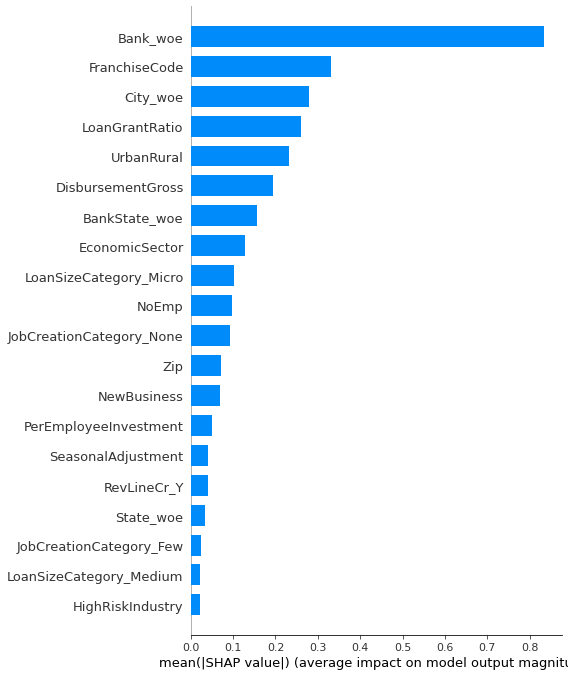

In [118]:
# Create the SHAP explainer for XGBoost
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)  # Where X_test is your test set features

# Plot summary of SHAP values for all features
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [124]:
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
# Thresholds for high confidence
high_confidence_threshold = 0.6
low_confidence_threshold = 0.4

# Predicted classes based on 0.5 probability threshold
y_pred = (y_pred_proba > 0.63).astype(int)

In [126]:
indices = {
    "high_confidence_correct_0": np.where((y_pred == 0) & (y_pred_proba <= low_confidence_threshold))[0][:2],
    "high_confidence_incorrect_0": np.where((y_pred == 1) & (y_pred_proba <= low_confidence_threshold))[0][:2],
    "high_confidence_correct_1": np.where((y_pred == 1) & (y_pred_proba >= high_confidence_threshold))[0][:2],
    "high_confidence_incorrect_1": np.where((y_pred == 0) & (y_pred_proba >= high_confidence_threshold))[0][:2]
}


In [128]:
def display_shap(index):
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values[index, :], X_test.iloc[index, :])

# Iterate over each scenario to display two SHAP plots
for label, idx_array in indices.items():
    print(f"\nScenario: {label}")
    for idx in idx_array:
        print(f"Displaying SHAP plot for index {idx}:")
        shap_plot = display_shap(idx)
        shap.save_html(f"{label}_index_{idx}.html", shap_plot)  # Optionally save to HTML
        display(shap_plot)


Scenario: high_confidence_correct_0
Displaying SHAP plot for index 0:


Displaying SHAP plot for index 1:



Scenario: high_confidence_incorrect_0

Scenario: high_confidence_correct_1
Displaying SHAP plot for index 7:


Displaying SHAP plot for index 8:



Scenario: high_confidence_incorrect_1
Displaying SHAP plot for index 58:


Displaying SHAP plot for index 103:


# Residual Analysis

In [225]:
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# SUMMARY

**Summary of Work**
The project involved building a predictive model using an XGBoost classifier to determine loan outcomes based on various features of loan applications. The steps included:

1) Data Importing and Preliminary Analysis: The dataset was imported and explored to understand the distribution and nature of the data.
2) Data Cleaning: Cleaning involved handling missing values, correcting data types, and normalizing the data.
Feature Engineering: 15 new features were created to capture more contextual information from the data.
3) Data Encoding: Categorical variables were encoded using one-hot encoding and weight of evidence (WOE) methods.
4) Model Training: An XGBoost model was trained with initial settings and evaluated.
5) Fine Tuning: GridSearchCV was used to find the optimal hyperparameters for the XGBoost model.
6) Threshold Calculation: An optimal threshold was calculated based on the F1 macro score to improve model performance.



**Summary of Findings**
1) Initial Model Performance: The initial model achieved an accuracy of 84.93% with an AUC of 0.6375, indicating moderate predictive power but room for improvement, especially in distinguishing between the classes (precision and recall for the minority class were low).
2) Feature Importance: The newly engineered features like Loan Size per Employee, Economic Sector, and Credit Utilization Ratio significantly impacted the model's performance, suggesting that financial ratios and sector-based risk assessments are critical for predicting loan outcomes.
3) Impact of Feature Engineering: The feature engineering steps provided significant improvements over a baseline model by capturing more complex patterns in the data.



**Summary of Model Performance**
1) Tuned Model Performance: After hyperparameter tuning, the best model achieved an AUC of 0.8419, a substantial improvement over the initial model.
2) Class Balance Handling: Adjusting the scale_pos_weight parameter helped in managing the class imbalance, optimizing the trade-off between sensitivity and specificity.
3) Validation Performance: The final validation AUC was 0.8236, indicating the model's good generalizability.


**Summary of Recommendations**
1) Continued Feature Exploration: Further investigate other potential features that could capture more nuanced patterns in the data, such as macroeconomic indicators or more detailed borrower financial health metrics.
2) Model Complexity: Consider exploring simpler models or ensemble methods that might provide comparable performance with less complexity and better interpretability.
3) Deployment Strategy: Develop a deployment strategy that includes periodic model retraining and updating as new loan data becomes available and economic conditions change.
4) Threshold Adjustment: Use the identified optimal threshold of 0.63 for classification to balance the trade-off between false positives and false negatives effectively, especially in a business context where false negatives (failing to identify a bad loan) might be more costly than false positives.